# UIUC Grid Demand: Solar Power + Dry Bulb Temperature

This notebook uses an Echo State Network(ESN) (from pyESN) to predict the solar generation at the University of Illinois.
Rather than one input, there are two inputs: Solar Power and Dry Bulb Temp. 
The following items are included:

1. An initial demonstration of the ESN with a 72-hour prediction.
2. Grid optimization over spectral radius and noise
3. Grid optimization over reservoir size and sparsity
4. Demonstrate the effect of training length on accuracy.
5. A final demonstration of the ESN with optimized hyper-parameters.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, "/home/dotson/research/cairo")


# custom libraries
from tools import MSE, esn_prediction, param_string, optimal_values
from optimizers import grid_optimizer
from sunrise import generate_elevation_series
from pyESN.pyESN import ESN

In [2]:
# import demand data
dataframe = pd.read_csv("../data/solarfarm_data.csv", usecols=['time','power_data'])[:-1]
solarpower = np.array(dataframe.power_data).astype('float64')

# normalize
norm = np.linalg.norm(solarpower)
solarpower_norm = solarpower/norm

In [3]:
start = str(dataframe.time[0])
end = '1/1/2019'
print(start, '\n', end)

2016-01-01 00:00:00 
 1/1/2019


In [4]:
feature = 'drytemp'
feature_df = pd.read_csv("../data/champaign_weatherdata.csv", usecols=['time',feature])
feature_df['time'] = pd.to_datetime(feature_df['time'])
mask = (feature_df.time > pd.to_datetime(start)) & (feature_df.time < pd.to_datetime(end))
feature_df = feature_df[mask]

feature_data = np.array(feature_df[feature]).astype('float64')

# normalize
norm_f = np.linalg.norm(feature_data)
feature_norm = feature_data/norm_f

In [5]:
time_range = pd.date_range(start='1/1/2016', end='1/1/2019', freq='h')[:len(solarpower)]
elevation = generate_elevation_series(time_range, timestamps=True)
norm_a = np.linalg.norm(elevation)
angles_norm = elevation/norm_a
print(f"Norm of elevation angles: {norm_a}")
print(f"Norm of demand: {norm}")

Norm of elevation angles: 5857.7502268658645
Norm of demand: 260004.41436762564


## Format the Input Data

In [6]:
print(solarpower_norm.shape,'\n',feature_norm.shape)

(26303,) 
 (26303,)


In [7]:
X_in = np.concatenate([[solarpower_norm, feature_norm, angles_norm]], axis=1)
    
print(f"Shape of X_in is {X_in.shape}")

Shape of X_in is (3, 26303)


In [8]:
params = {'n_reservoir':1000, 
          'sparsity':0.1, 
          'rand_seed':85, 
          'rho':1.5, 
          'noise':0.0001, 
          'future':72, 
          'window':72, 
          'trainlen':8000}

In [9]:
futureTotal = params['future']
time_range = np.array(dataframe.time)
hour_range = np.arange(0, len(time_range), 1)

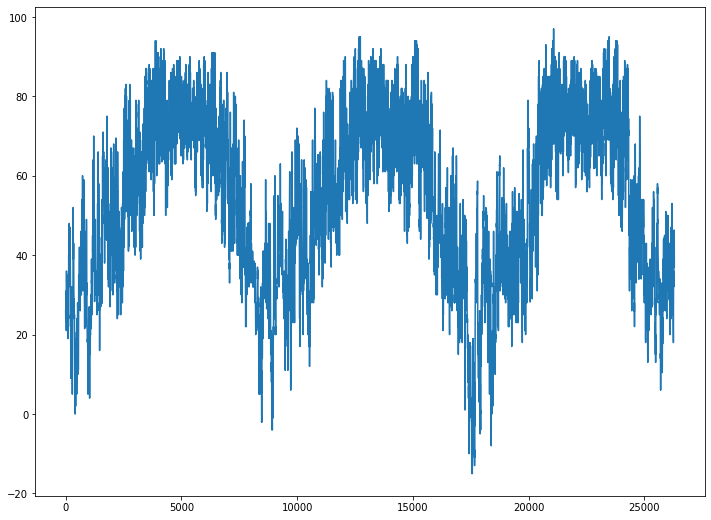

In [10]:
plt.figure(figsize=(12,9), facecolor='w')
plt.plot(hour_range, feature_data)
plt.show()

## 1. Initial Demonstration


In [11]:
tic = time.perf_counter()

init_pred = esn_prediction(X_in.T, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 3.64 seconds
This simulation took 0.06 minutes


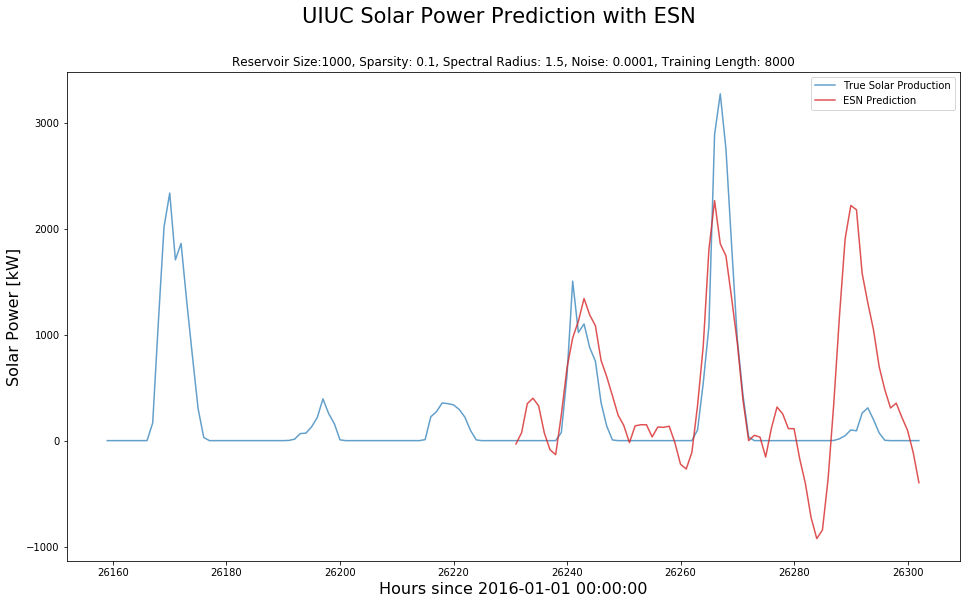

In [12]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Solar Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("Solar Power [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*solarpower_norm[-2*futureTotal:],'b',label="True Solar Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*init_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 2. Grid Optimization Over Spectral Radius and Noise

Optimizing over ['rho', 'noise']:
rho = 0.5, noise = 0.0001, MSE=0.002488474039749484
rho = 0.5, noise = 0.0003, MSE=0.0028805771482464182
rho = 0.5, noise = 0.0007, MSE=0.003010822214052112
rho = 0.5, noise = 0.001, MSE=0.0030095188240310496
rho = 0.5, noise = 0.003, MSE=0.002979809524126368
rho = 0.5, noise = 0.005, MSE=0.0029295314167511396
rho = 0.5, noise = 0.007, MSE=0.0032383155620141725
rho = 0.5, noise = 0.01, MSE=0.003900144723454819
rho = 0.7, noise = 0.0001, MSE=0.0025753055658866934
rho = 0.7, noise = 0.0003, MSE=0.002727530010572662
rho = 0.7, noise = 0.0007, MSE=0.002827423950781627
rho = 0.7, noise = 0.001, MSE=0.0028221133696177416
rho = 0.7, noise = 0.003, MSE=0.002830199546901016
rho = 0.7, noise = 0.005, MSE=0.002711931604116357
rho = 0.7, noise = 0.007, MSE=0.0026939027022979665
rho = 0.7, noise = 0.01, MSE=0.003033728320981678
rho = 0.9, noise = 0.0001, MSE=0.0024332014774706224
rho = 0.9, noise = 0.0003, MSE=0.002983737963319411
rho = 0.9, noise = 0.0007, MSE=0.0

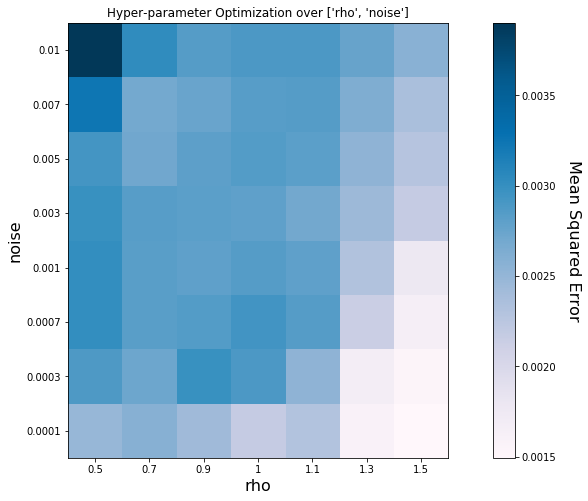

In [13]:
tic = time.perf_counter()
radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]

radiusxnoise_loss = grid_optimizer(X_in.T,
                      params,
                      args=['rho', 'noise'],
                      xset=radius_set,
                      yset=noise_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [14]:
opt_radius, opt_noise = optimal_values(radiusxnoise_loss, radius_set, noise_set)
params['rho'] = opt_radius
params['noise'] = opt_noise
print(f'The optimal set is:\nspectrum radius = {opt_radius} \nnoise = {opt_noise}')

The optimal set is:
spectrum radius = 1.5 
noise = 0.0001


### 3. Grid Optimization Over Reservoir Size and Sparsity

The algorithm is unstable when ``n_reservoir == trainlen``.

Optimizing over ['n_reservoir', 'sparsity']:
n_reservoir = 600, sparsity = 0.005, MSE=0.0013266457987861455
n_reservoir = 600, sparsity = 0.01, MSE=0.0013324849667310785
n_reservoir = 600, sparsity = 0.03, MSE=0.0013616042889119675
n_reservoir = 600, sparsity = 0.05, MSE=0.001297380975724346
n_reservoir = 600, sparsity = 0.1, MSE=0.001348047471203812
n_reservoir = 600, sparsity = 0.15, MSE=0.00202629659745925
n_reservoir = 600, sparsity = 0.2, MSE=0.0021440781443833458
n_reservoir = 800, sparsity = 0.005, MSE=0.001744414389532849
n_reservoir = 800, sparsity = 0.01, MSE=0.001552030062496011
n_reservoir = 800, sparsity = 0.03, MSE=0.0017599865952944048
n_reservoir = 800, sparsity = 0.05, MSE=0.00157296276103882
n_reservoir = 800, sparsity = 0.1, MSE=0.0019120560573336871
n_reservoir = 800, sparsity = 0.15, MSE=0.0018697244812650327
n_reservoir = 800, sparsity = 0.2, MSE=0.0035599528335995404
n_reservoir = 1000, sparsity = 0.005, MSE=0.0014298851670887913
n_reservoir = 1000, sparsity = 0.

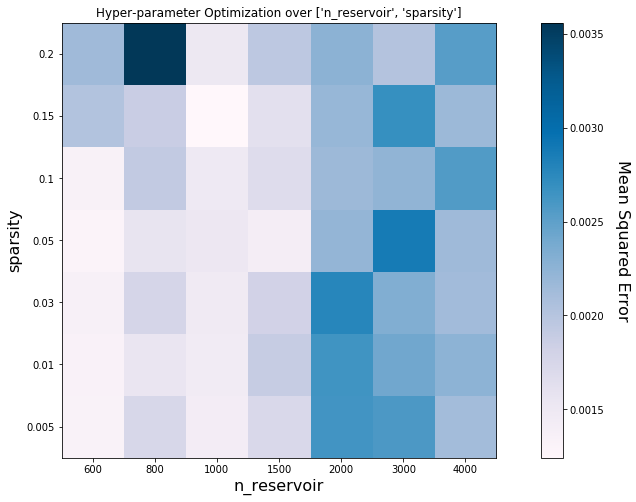

In [15]:
tic = time.perf_counter()
reservoir_set = [600, 800, 1000, 1500, 2000, 3000, 4000]
sparsity_set = [0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

sizexsparsity_loss = grid_optimizer(X_in.T,
                      params,
                      args=['n_reservoir', 'sparsity'],
                      xset=reservoir_set,
                      yset=sparsity_set,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [16]:
opt_size, opt_sparsity = optimal_values(sizexsparsity_loss, reservoir_set, sparsity_set)
params['n_reservoir'] = opt_size
params['sparsity'] = opt_sparsity
print(f'The optimal set is:\nreservoir size = {opt_size} \nsparsity = {opt_sparsity}')

The optimal set is:
reservoir size = 1000 
sparsity = 0.15


### 4. Demonstrate the Effect of Training Length

Once again, the algorithm is unstable when ``n_reservoir == trainlen``.

We should expect that MSE will decrease as training length increases.

Optimizing over ['trainlen']:
trainlen = 5000, MSE=0.001853642773722864
trainlen = 5300, MSE=0.002422178181318026
trainlen = 5600, MSE=0.001449871617841509
trainlen = 5900, MSE=0.0015269438300698661
trainlen = 6200, MSE=0.001419354666539285
trainlen = 6500, MSE=0.002719670521462146
trainlen = 6800, MSE=0.0017127639383585896
trainlen = 7100, MSE=0.0014246473783286894
trainlen = 7400, MSE=0.001444942146052939
trainlen = 7700, MSE=0.0013864264041151407
trainlen = 8000, MSE=0.001241470292204819
trainlen = 8300, MSE=0.002008200785831846
trainlen = 8600, MSE=0.001114939327866002
trainlen = 8900, MSE=0.0014153685588918308
trainlen = 9200, MSE=0.0013018797058386197
trainlen = 9500, MSE=0.0014652752210367343
trainlen = 9800, MSE=0.0014216857770508744
trainlen = 10100, MSE=0.0016061817693548766
trainlen = 10400, MSE=0.0014081356884498009
trainlen = 10700, MSE=0.0016275199117488728
trainlen = 11000, MSE=0.0012820141237949033
trainlen = 11300, MSE=0.001406598380798362
trainlen = 11600, MSE=0.00162

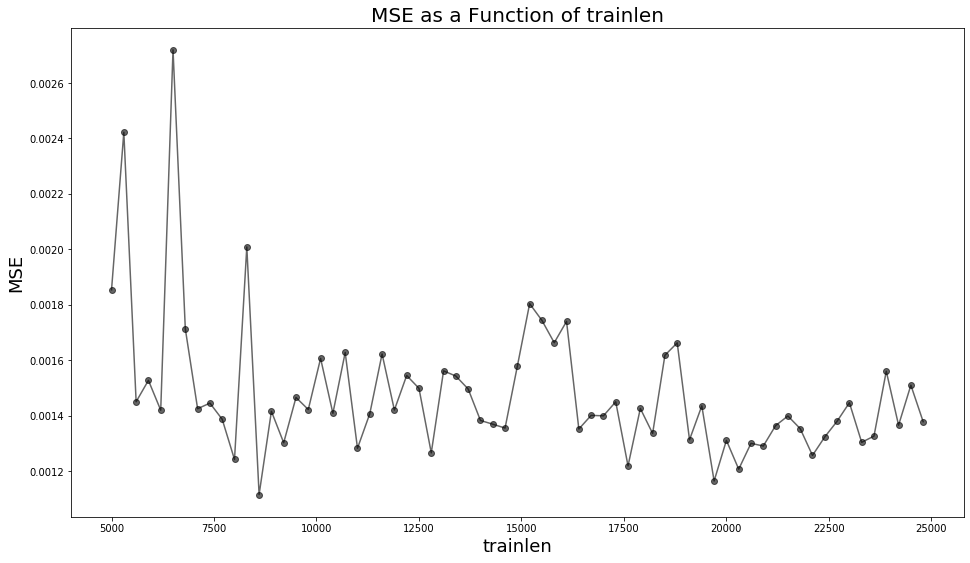

In [17]:
tic = time.perf_counter()
trainingLengths = np.arange(5000,25000,300)
trainlen_loss = grid_optimizer(X_in.T,
                      params,
                      args=['trainlen'],
                      xset=trainingLengths,
                      verbose=True,
                      visualize=True)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

In [18]:
minloss = np.min(trainlen_loss)
index_min = np.where(trainlen_loss == minloss)
l_opt = trainingLengths[index_min][0]
params['trainlen'] = l_opt

print(f"Training length with minimum error was: {l_opt}")

Training length with minimum error was: 8600


### 5. Optimized Demand Prediction


In [19]:
tic = time.perf_counter()

opt_pred = esn_prediction(X_in.T, params)

toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 3.61 seconds
This simulation took 0.06 minutes


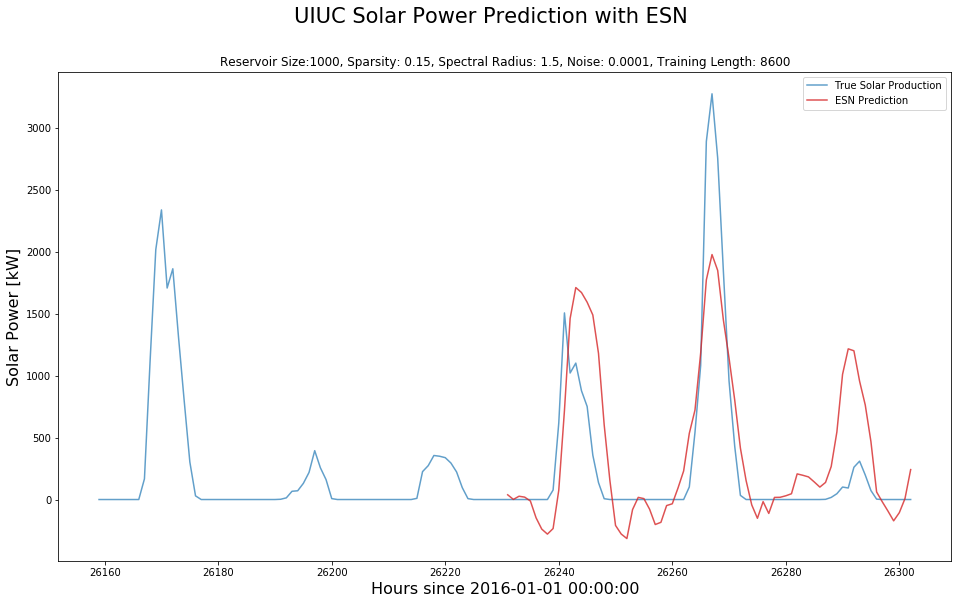

In [20]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Solar Power Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("Solar Power [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*solarpower_norm[-2*futureTotal:],'b',label="True Solar Production", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*opt_pred.T[0],  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 6. Uncertainty Calculation

In [21]:
params = {'n_reservoir':opt_size, 
          'sparsity':opt_sparsity, 
          'rand_seed':85, 
          'rho':opt_radius, 
          'noise':opt_noise, 
          'future':72, 
          'window':72, 
          'trainlen':l_opt}

rand_seeds = [85, 21, 22, 30, 122, 5, 79]

In [22]:
N = len(rand_seeds)
predictions = np.ones((N, futureTotal))

tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X_in.T, params)
    predictions[x] = prediction.T[0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 22.94 seconds
This simulation took 0.38 minutes


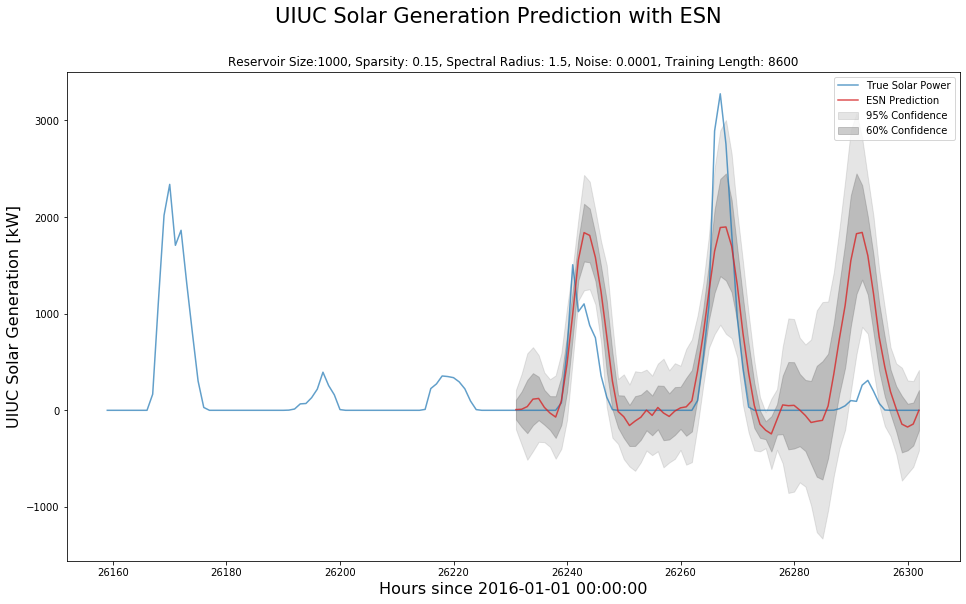

In [23]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Solar Generation Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Solar Generation [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*solarpower_norm[-2*futureTotal:],'b',label="True Solar Power", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*mean_prediction,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + 2 * std_prediction),
                 norm*(mean_prediction - 2 * std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + std_prediction),
                 norm*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()

In [24]:
params['window'] = 12

N = len(rand_seeds)
predictions = np.ones((N, futureTotal))

tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X_in.T, params)
    predictions[x] = prediction.T[0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 93.26 seconds
This simulation took 1.55 minutes


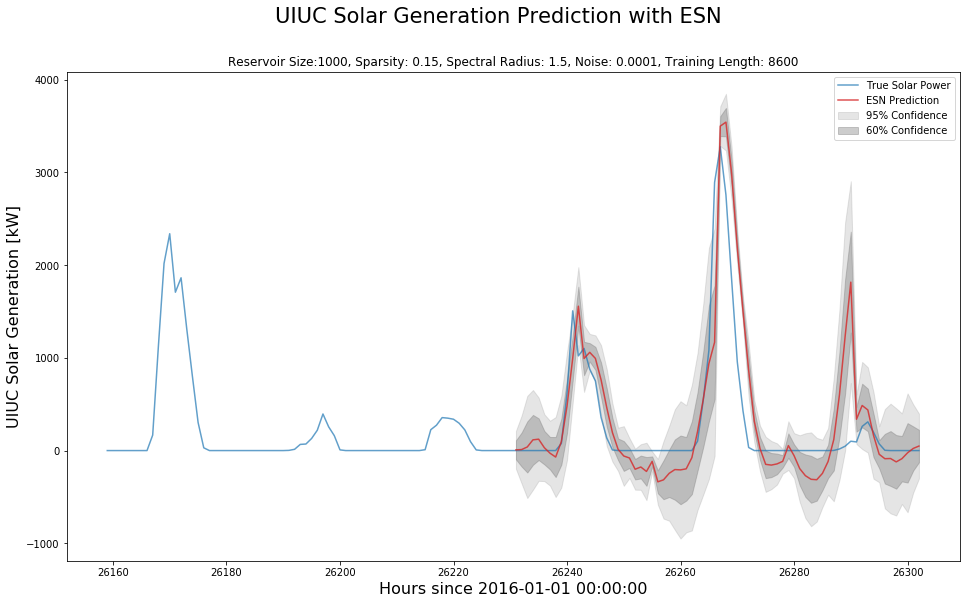

In [25]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Solar Generation Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Solar Generation [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*solarpower_norm[-2*futureTotal:],'b',label="True Solar Power", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*mean_prediction,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + 2 * std_prediction),
                 norm*(mean_prediction - 2 * std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + std_prediction),
                 norm*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()

In [27]:
params['window'] = 1

N = len(rand_seeds)
predictions = np.ones((N, futureTotal))

tic = time.perf_counter()

for x, seed in enumerate(rand_seeds):
    print(f"Running Simulation {x}")
    params['rand_seed'] = seed
    prediction = esn_prediction(X_in.T, params)
    predictions[x] = prediction.T[0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

Running Simulation 0
Running Simulation 1
Running Simulation 2
Running Simulation 3
Running Simulation 4
Running Simulation 5
Running Simulation 6
This simulation took 1549.93 seconds
This simulation took 25.83 minutes


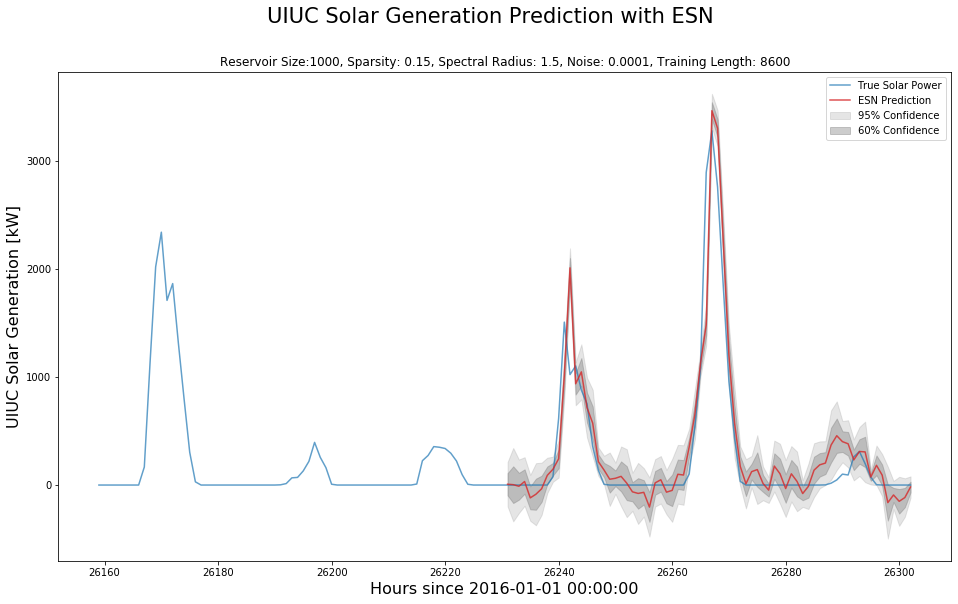

In [28]:
plt.figure(figsize=(16,9))
plt.suptitle("UIUC Solar Generation Prediction with ESN", fontsize=21)
plt.title(param_string(params))
plt.ylabel("UIUC Solar Generation [kW]", fontsize=16)
plt.xlabel(f"Hours since {time_range[0]}", fontsize=16)
# plot the truth
plt.plot(hour_range[-2*futureTotal:],norm*solarpower_norm[-2*futureTotal:],'b',label="True Solar Power", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(hour_range[-futureTotal:], norm*mean_prediction,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + 2 * std_prediction),
                 norm*(mean_prediction - 2 * std_prediction),
                 color='gray', alpha=0.2, label='95% Confidence')
plt.fill_between(hour_range[-futureTotal:],
                 norm*(mean_prediction + std_prediction),
                 norm*(mean_prediction - std_prediction),
                 color='gray', alpha=0.4
                 , label='60% Confidence')
plt.legend()